## NOTE - all cells finish running in less than five minutes on my Apple M2 Chip Computer!

In [32]:
from queue import PriorityQueue
import random
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

class KNearesetNeighborsTrainer:
    """This class takes in data as a pandas data frame along with a block size and parameter for the k nearest neighbors, 
    """
    
    def __init__(self, file_name: str, delimiter: str, id_column_name: str, classification_column_name: str, k : int, n : int):
        """Initialize a KNearestNeighborsTrainer, which takes in a data frame of all its points, a parameter k for its so-named training algorithm, and the number of different blocks it should partition its data into

        Args:
            file_name (str): The file from which to read in data
            k (int): The number of closest other points used to guess if a certain point belongs to a given classification
            n (int): The number of different blocks to partition the training points into
        """
        # Record a couple attributes
        self.__id_column_name = id_column_name
        self.__classification_column_name = classification_column_name

        # First let's read in our data
        read_from = open(file_name, "r")
        points_as_strings = read_from.readlines()

        # Let's look at the first line, which reveals the point attributes which are numeric
        header = points_as_strings[0][:-1] # Remember to omit the '\n' character
        attributes = header.split(delimiter)
        class_idx = -1
        id_idx = -1
        numerical_value_indices = []
        for i, attr in enumerate(attributes):
            if attr == classification_column_name:
                class_idx = i
            elif attr == id_column_name:
                id_idx = i
            else:
                numerical_value_indices.append(i)
        points_as_strings = points_as_strings[1:]

        self.__data_length = len(points_as_strings)
        read_from.close()
        self.__raw_data_array = np.zeros(shape=(self.__data_length,len(numerical_value_indices)))
        unique_labels = set()
        self.__labels = []
        self.__names = []
        self.__points_as_dicts = []
        for block_idx, point_string in enumerate(points_as_strings):
            # First omit the '\n' character in each row of data corresponding to a point
            point_attributes = point_string[:-1].split(delimiter)

            # Record the unique id and class of this point
            self.__labels.append(int(point_attributes[class_idx]))
            unique_labels.add(int(point_attributes[class_idx]))
            self.__names.append(point_attributes[id_idx])

            # Record all numerical elements of the points 
            for i, idx in enumerate(numerical_value_indices):
                self.__raw_data_array[block_idx][i] += float(point_attributes[idx])
            
            # Turn this point into a dictionary
            point_as_dict = {}
            point_as_dict[id_column_name] = self.__names[block_idx]
            point_as_dict[classification_column_name] = self.__labels[block_idx]
            self.__points_as_dicts.append(point_as_dict)
 
        # Normalize the data array along each axis:
        self.__normalized_data_array = normalize(X=self.__raw_data_array, norm='l2', axis=1, copy=True)

        # K nearest points parameter
        self.__k = k
        
        # To break the data up into training blocks
        self.__block_size = len(points_as_strings)//n
         # For a given point, we need to know which block it's in
        self.__find_block = {}
        # We want to break up into blocks randomly
        indices = random.sample(range(0, self.__data_length), self.__data_length)
        rand_indx_posn = 0
        # Let's also have a list of lists of node_ids - one list of node_ids for each block
        self.__blocks = [[] for _ in range(n)]
        for i in range(n):
            # In case our number of blocks does not evenly divide our data, the last block of data may have fewer elements
            this_block_size = self.__data_length - i*self.__block_size if i == n-1 else self.__block_size
            for _ in range(this_block_size):
                next_random_idx = indices[rand_indx_posn]
                rand_indx_posn += 1
                next_random_point = self.__points_as_dicts[next_random_idx]
                self.__find_block[next_random_point[id_column_name]] = i
                self.__blocks[i].append(next_random_point[id_column_name])
            
        # For each data point, store its actual label keyed by its id
        self.__values = {}
        
        # Store our model's TEST prediction of each point's label by that point's id
        self.__test_predictions = {}
        # Store our model's TRAIN prediction of each point's label by that point's id
        self.__train_predictions = {}
        
        # This dictionary maps point id to that point's vector
        point_vectors = {}
        
        # Record all of our points
        self.__distances = {} # For any two points, know their distances
        self.__used_in_queue = {} # For any two points, know if each has been used in the queue of the other
        for index, row in enumerate(self.__points_as_dicts):
            self.__values[row[id_column_name]] = row[classification_column_name]
            point_vectors[row[id_column_name]] = self.__normalized_data_array[index]
            self.__test_predictions[row[id_column_name]] = None
            self.__train_predictions[row[id_column_name]] = None
            self.__distances[row[id_column_name]] = {}
            self.__used_in_queue[row[id_column_name]] = {}

        print("Data points processed! The next step is O(n^2) so apologies for the wait...")

        # Record each point distance and record if each point has used each respective other point in its training priority queue
        for name_1 in self.__distances:
            for name_2 in self.__distances:
                # The distance between a point and itself is 0.0
                self.__distances[name_1][name_2] = np.linalg.norm(point_vectors[name_1] - point_vectors[name_2])
                self.__used_in_queue[name_1][name_2] = False

        # Each block of points stores a dictionary that stores a {point_name: closest_points_priority_queue} dictionary for all points in that block
        # Each point has a corresponding 'train all' queue and 'train error' queue
        self.__train_all_queues = {}
        self.__train_error_queues = {}
        for name_1 in self.__distances.keys():
            self.__train_all_queues[name_1] = PriorityQueue()
            self.__train_error_queues[name_1] = PriorityQueue()
            category_counts = {}
            name_1_block = self.__find_block[name_1]
            for name_2 in self.__distances.keys():
                # Everything will go in the train_all priority queue - when we actually use this queue though, we won't count nodes that come out as part of the same block of whatever node the heap belongs to
                self.__train_all_queues[name_1].put(self.__DistancedNode(id=name_2, dist=self.__distances[name_1][name_2]))
                # Regarding the train_error priority queue, we are only going to input k nodes from each classification which are NOT part of the same block - we'll still throw in nodes that ARE part of the same block but they won't contribute to the count of the first k nodes from their respective category
                name_2_value = self.__values[name_2]
                name_2_block = self.__find_block[name_2]
                if name_2_block != name_1_block:
                    if name_2_value not in category_counts.keys():
                        category_counts[name_2_value] = 1
                        self.__train_error_queues[name_1].put(self.__DistancedNode(id=name_2, dist=self.__distances[name_1][name_2]))
                        self.__used_in_queue[name_1][name_2] = True
                    elif category_counts[name_2_value] < k:
                        category_counts[name_2_value] += 1
                        self.__train_error_queues[name_1].put(self.__DistancedNode(id=name_2, dist=self.__distances[name_1][name_2]))
                        self.__used_in_queue[name_1][name_2] = True
                else:
                    # This node is part of the same block, so we'll go ahead and throw the node in as long as the count of the category is not yet k - and it will NOT contribute to the category count
                    if name_2_value not in category_counts.keys() or category_counts[name_2_value] < k:
                        self.__train_error_queues[name_1].put(self.__DistancedNode(id=name_2, dist=self.__distances[name_1][name_2]))
                        self.__used_in_queue[name_1][name_2] = True

        # Finally, we need a set of miss-classified points - after each block of training in the 'train_error' algorithm, this has been newly filled with miss-classified points
        self.__freshly_missclassified = set()
        # We also need a set of all points miss-classified EVER during a 'train_error' block, so that we don't add repeats into __freshly_missclassified
        self.__ever_missclassified = set()

        print("Training structure set up!")
    
    class __DistancedNode:
        """This inner class is an object that has two attributes - a position label and a given distance from that position from a certain other point that this class does not need to know about
        """
        def __init__(self, id : str, dist : float):
            self.id = id
            self.dist = dist
            
        def __gt__(self, other):
            return self.dist > other.dist

        def __eq__(self, other):
            return self.dist == other.dist
        
        def __lt__(self, other):
            return self.dist < other.dist
                    
    def __train(self, i : int, queue_dictionary : dict[str,PriorityQueue[__DistancedNode]]):
        """Perform the 'store all' variant of the k-nearest-neighbors training on the ith block of data

        Args:
            i (int): index for the training block
        """
        for node_id, closest_nodes in queue_dictionary.items():
            prediction_counts = {}
            used_for_prediction = []
            if self.__find_block[node_id] == i:
                # Testing on this point
                same_block = []
                # Empty k points from this point's queue of closest points - only points that are in different blocks count
                # But still remember the points not in the same block because we'll empty and put them back as well
                while len(used_for_prediction) < self.__k:
                    next_closest = closest_nodes.get()
                    other_name = next_closest.id
                    if self.__find_block[other_name] != i:
                        # Different block - contributes to the prediction
                        used_for_prediction.append(next_closest)
                        value = self.__values[next_closest.id]
                        if value not in prediction_counts.keys():
                            prediction_counts[value] = 1
                        else:
                            prediction_counts[value] += 1
                    else:
                        # Not a different block - but we still empty it from the queue
                        same_block.append(next_closest)

                # Now put all points back
                for point in used_for_prediction:
                    queue_dictionary[node_id].put(point)
                for point in same_block:
                    queue_dictionary[node_id].put(point)
                    
                # Now see which classification type had the highest count
                record_prediction_count = 0
                record_prediction = -1
                for pred, count in prediction_counts.items():
                    if count > record_prediction_count:
                        record_prediction_count = count
                        record_prediction = pred
                self.__test_predictions[node_id] = record_prediction

                # See if we were right
                if self.__values[node_id] != record_prediction and node_id not in self.__ever_missclassified:
                    self.__freshly_missclassified.add(node_id)
            else:
                # Training on this point
                while len(used_for_prediction) < self.__k:
                    next_closest = closest_nodes.get()
                    other_name = next_closest.id
                    # Different block - contributes to the prediction
                    used_for_prediction.append(next_closest)
                    value = self.__values[next_closest.id]
                    if value not in prediction_counts.keys():
                        prediction_counts[value] = 1
                    else:
                        prediction_counts[value] += 1
                    
                # Now put all points back
                for point in used_for_prediction:
                    queue_dictionary[node_id].put(point)
                    
                # Now see which classification type had the highest count
                record_prediction_count = 0
                record_prediction = -1
                for pred, count in prediction_counts.items():
                    if count > record_prediction_count:
                        record_prediction_count = count
                        record_prediction = pred
                self.__train_predictions[node_id] = record_prediction
        
                # See if we were right
                if self.__values[node_id] != record_prediction and node_id not in self.__ever_missclassified:
                    self.__freshly_missclassified.add(node_id)

        print(f"Block {i} done training via algorithm!")
        
    def train_all(self):
        """Iterate over each block of data that is automatically partitioned in the constructor, and train that block of data using all other blocks of data with the 'store all' KNN algorithm
        """
        acc_train = 0
        acc_test = 0
        for i, block in enumerate(self.__blocks):
            self.__train(i, self.__train_all_queues)
            # Proportion of current training population classified correctly
            acc_train += sum([sum([1 for point_id in self.__names if ((self.__find_block[point_id] != i) and (self.__train_predictions[point_id] == self.__values[point_id]))])]) / (len(self.__names) - len(block))
            # Proportion of current test population classified correctly
            acc_test += sum([1 for point_id in block if (self.__test_predictions[point_id]==self.__values[point_id])]) / len(block)

        print(f"Train All Train Accuracy: {100*acc_train/(len(self.__blocks))}%")
        print(f"Train All Test Accuracy: {100*acc_test/len(self.__blocks)}%")
    
    def train_error(self):
        """Iterate over each block of data that is automatically partitioned in the constructor, and train that block of data using all other blocks of data with the 'store error' KNN algorithm
        """
        acc_train = 0
        acc_test = 0
        for i, block in enumerate(self.__blocks):
            self.__train(i, self.__train_error_queues)
            # Proportion of current training population classified correctly
            acc_train += sum([sum([1 for point_id in self.__names if ((self.__find_block[point_id] != i) and (self.__train_predictions[point_id] == self.__values[point_id]))])]) / (len(self.__names) - len(block))
            # Proportion of current test population classified correctly
            acc_test += sum([1 for point_id in block if (self.__test_predictions[point_id]==self.__values[point_id])]) / len(block)
            # Since this is error training, all miss_classified points go into all other points' queues
            while self.__freshly_missclassified:
                # Move all freshly miss_classified points into the ever_missclassified set
                newly_missclassified_point = self.__freshly_missclassified.pop()
                self.__ever_missclassified.add(newly_missclassified_point)
                for node_id in self.__names:
                    if not self.__used_in_queue[node_id][newly_missclassified_point]:
                        self.__train_error_queues[node_id].put(self.__DistancedNode(id=newly_missclassified_point, dist=self.__distances[node_id][newly_missclassified_point]))
                        self.__used_in_queue[node_id][newly_missclassified_point] = True

        print(f"Train Errors Train Accuracy: {100*acc_train/(len(self.__blocks))}%")
        print(f"Train Errors Test Accuracy: {100*acc_test/len(self.__blocks)}%")
    
    def plot_predictions(self):
        # If we do not have two-dimensional data, do not plot
        if self.__raw_data_array.shape[1] != 2:
            return

        # Plot our data with its actual classifications
        fig, ax = plt.subplots()
        scatter = ax.scatter(self.__raw_data_array[:, 0], self.__raw_data_array[:, 1], c=self.__labels)
        # Produce a legend with the unique colors from the scatter
        # Source: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html#sphx-glr-gallery-lines-bars-and-markers-scatter-with-legend-py
        legend = ax.legend(*scatter.legend_elements(),
                            loc="lower left", title="Classes")
        ax.add_artist(legend)
        plt.title("Model Data")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()
        fig.clear()
        
        # Now do the dame with predictions
        fig, ax = plt.subplots()
        scatter = ax.scatter(self.__raw_data_array[:, 0], self.__raw_data_array[:, 1], c=[self.__test_predictions[name] for name in self.__names])
        # Produce a legend with the unique colors from the scatter
        # Source: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html#sphx-glr-gallery-lines-bars-and-markers-scatter-with-legend-py
        # legend = ax.legend(*scatter.legend_elements(),
        #                     loc="lower left", title="Classes")
        # ax.add_artist(legend)
        plt.title("Model Test Prediction")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()
        fig.clear()

Data points processed! The next step is O(n^2) so apologies for the wait...
Training structure set up!
Block 0 done training via algorithm!
Block 1 done training via algorithm!
Block 2 done training via algorithm!
Block 3 done training via algorithm!
Block 4 done training via algorithm!
Train All Train Accuracy: 82.4%
Train All Test Accuracy: 76.6%


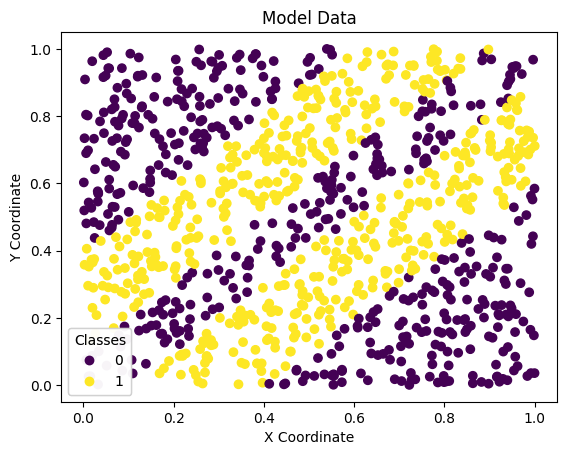

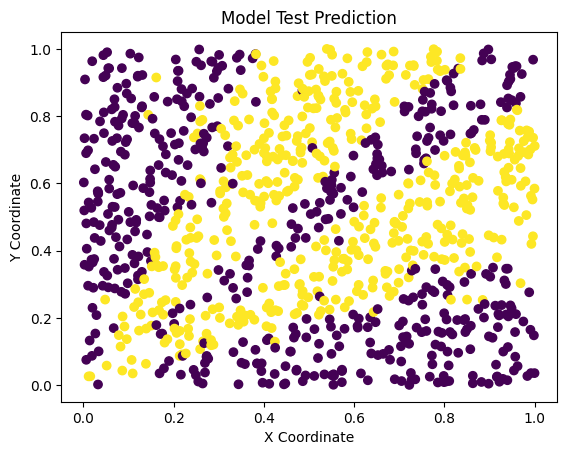

In [33]:
trainer = KNearesetNeighborsTrainer(file_name="labeled-examples", delimiter=" ", id_column_name="id", classification_column_name="class", k=10, n=5)
trainer.train_all()
trainer.plot_predictions()

Data points processed! The next step is O(n^2) so apologies for the wait...
Training structure set up!
Block 0 done training via algorithm!
Block 1 done training via algorithm!
Block 2 done training via algorithm!
Block 3 done training via algorithm!
Block 4 done training via algorithm!
Train Errors Train Accuracy: 69.7%
Train Errors Test Accuracy: 64.8%


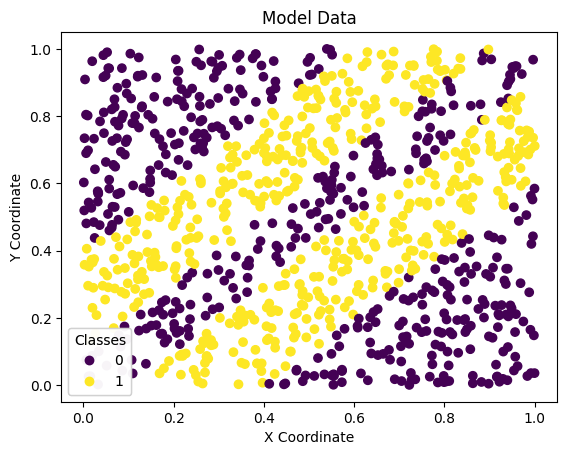

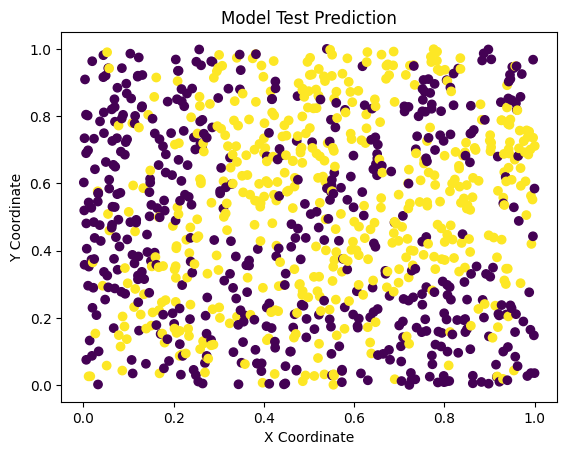

In [34]:
trainer = KNearesetNeighborsTrainer(file_name="labeled-examples", delimiter=" ", id_column_name="id", classification_column_name="class", k=10, n=5)
trainer.train_error()
trainer.plot_predictions()

In [35]:
trainer = KNearesetNeighborsTrainer(file_name="winequality.csv", delimiter=";", id_column_name="\"id\"", classification_column_name="\"type\"", k=10, n=5)
trainer.train_all()

Data points processed! The next step is O(n^2) so apologies for the wait...


In [11]:
trainer = KNearesetNeighborsTrainer(file_name="winequality.csv", delimiter=";", id_column_name="\"id\"", classification_column_name="\"type\"", k=10, n=5)
trainer.train_error()

Data points processed! The next step is O(n^2) so apologies for the wait...
Training structure set up!
Block 0 done training via algorithm!
Block 1 done training via algorithm!
Block 2 done training via algorithm!
Block 3 done training via algorithm!
Block 4 done training via algorithm!
Train Errors Test Accuracy: 91.41128485874845%
Train Errors Train Accuracy: 90.62639713681553%
